In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv


In [2]:
# IMPORTNG THE NECESSARY LIBARIES
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image

Using TensorFlow backend.


In [3]:
# SETTING THE PARAMETER VALUES
img_rows= 28
img_cols= 28
channel= 1
img_shape= (img_rows, img_cols, channel)
latent_dims= 100

* Function for generator building generator model

In [4]:
def build_generator():
    model= Sequential()
    model.add(Dense(128*7*7, activation= "relu", input_dim= latent_dims))
    model.add(Reshape((7,7,128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size= 3, padding= "same"))
    model.add(BatchNormalization(momentum= 0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64,kernel_size= 3, padding= "same"))
    model.add(BatchNormalization(momentum= 0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channel, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    model.summary()
    #noise= Input(shape= (latent_dims,))
    #img= model(noise)
    return(model)

In [5]:
Generator= build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 128)       0         
__________

In [6]:
Generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 128)       0         
__________

* Defining a function to build a discriminator model

In [7]:
def build_discriminator():
    model= Sequential()
    model.add(Conv2D(32, kernel_size= 3, strides= 2, input_shape= img_shape, padding= "same"))
    model.add(LeakyReLU(alpha= 0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size= 3, strides= 2, padding= "same"))
    model.add(ZeroPadding2D(padding= ((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img= Input(shape= img_shape)
    validity= model(img)
    return( Model(img, validity))

In [8]:
Descriminator= build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

In [9]:
Descriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 393729    
Total params: 393,729
Trainable params: 392,833
Non-trainable params: 896
_________________________________________________________________


* Building GAN for the model

In [10]:
# combining the desc and gen model to create funal gan model
optimizer= Adam(0.0002, 0.5)
Descriminator.compile(loss= "binary_crossentropy", optimizer= optimizer, metrics= ["accuracy"])
z= Input(shape= (100,))
img= Generator(z)
Descriminator.trainable= False
valid= Descriminator(img)
combined= Model(z, valid)
combined.compile(loss= "binary_crossentropy", optimizer= optimizer)
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         856193    
_________________________________________________________________
model_1 (Model)              (None, 1)                 393729    
Total params: 1,249,922
Trainable params: 855,809
Non-trainable params: 394,113
_________________________________________________________________


* Function for drawing the images

In [11]:
# function for plotting the images
def plot_generated_images(epoch, generator, examples= 100, dims= (10,10), figsize= (10, 10)):
    noise= np.random.normal(0,1,size= [examples, 100])
    gen_img= generator.predict(noise)
    plt.figure(figsize= figsize)
    for i in range(gen_img.shape[0]):
        plt.subplot(dims[0], dims[1], i+1)
        plt.imshow(gen_img[i].reshape(28,28), interpolation= "nearest")
        plt.axis("off")
    plt.tight_layout()
    

* DEFINING A FUNCTION TO TRAIN

In [12]:
# function for training
def train(epochs, batch_size= 128, save_interval= 50):
    os.makedirs("Images", exist_ok= True)
    (X_train,_), (_,_)= mnist.load_data()
    X_train= X_train/127.5-1.
    X_train= np.expand_dims(X_train, axis= 3)
    valid= np.ones((batch_size,1))
    fake= np.zeros((batch_size, 1))
    for epoch in range(epochs):
        idx= np.random.randint(0, X_train.shape[0], batch_size)
        real_img= X_train[idx]
        noise= np.random.normal(0,1,(batch_size, latent_dims))
        fake= Generator.predict(noise)
        data= np.concatenate([real_img,fake])
        data_idx= np.random.randint(0, 2*batch_size,2*batch_size)
        data=data[data_idx]
        label= np.zeros(2*batch_size)
        label[:batch_size]= 1
        label= label[data_idx]
    
        # Train the Discrimiator
        Descriminator.trainable= True
        d_loss= Descriminator.train_on_batch(data,label)
        
        Descriminator.trainable= False
        gan_loss= combined.train_on_batch(noise, valid)
        if(epoch%10==0):
            print("%d [D loss: %f, acc= %.2f%%] [G loss : %f]"%(epoch, d_loss[0], 100*d_loss[1],gan_loss))
            plot_generated_images(epoch, Generator)

11493376/11490434 [==============================] - 0s 0us/step
0 [D loss: 1.471615, acc= 46.48%] [G loss : 1.356436]
10 [D loss: 0.144651, acc= 95.31%] [G loss : 1.083164]
20 [D loss: 0.031677, acc= 100.00%] [G loss : 0.687552]
30 [D loss: 0.013107, acc= 100.00%] [G loss : 0.599850]
40 [D loss: 0.020609, acc= 100.00%] [G loss : 0.541581]
50 [D loss: 0.006262, acc= 100.00%] [G loss : 0.647874]
60 [D loss: 0.005675, acc= 100.00%] [G loss : 0.826188]
70 [D loss: 0.005420, acc= 100.00%] [G loss : 0.470865]
80 [D loss: 0.010768, acc= 100.00%] [G loss : 0.648809]
90 [D loss: 0.008009, acc= 100.00%] [G loss : 0.603813]


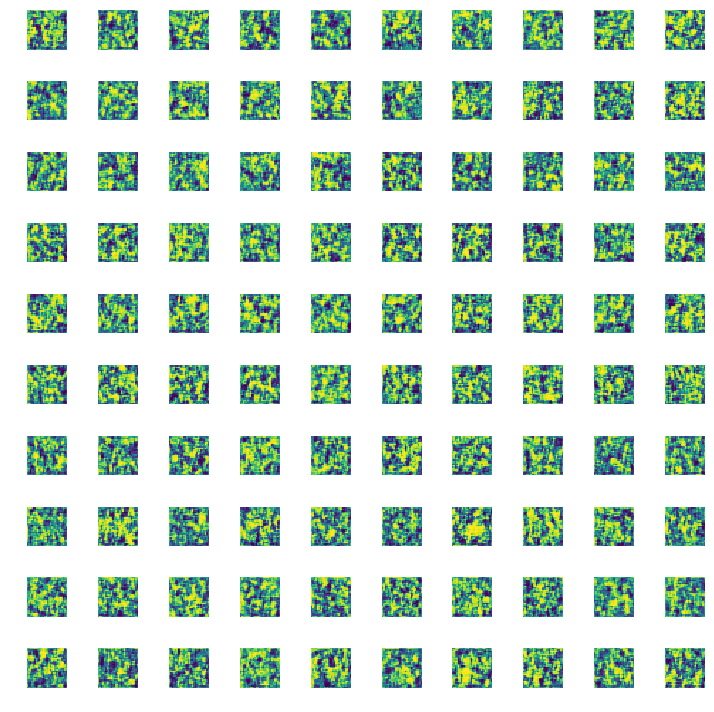

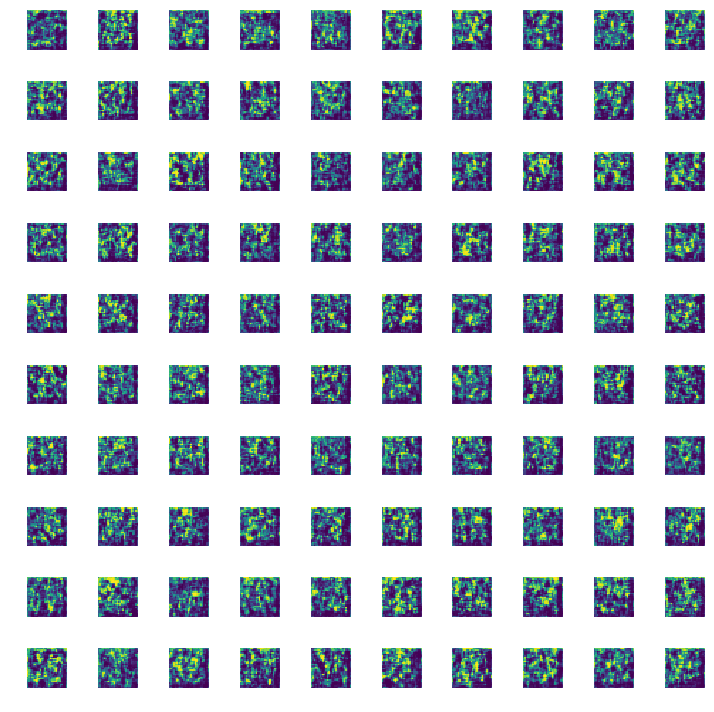

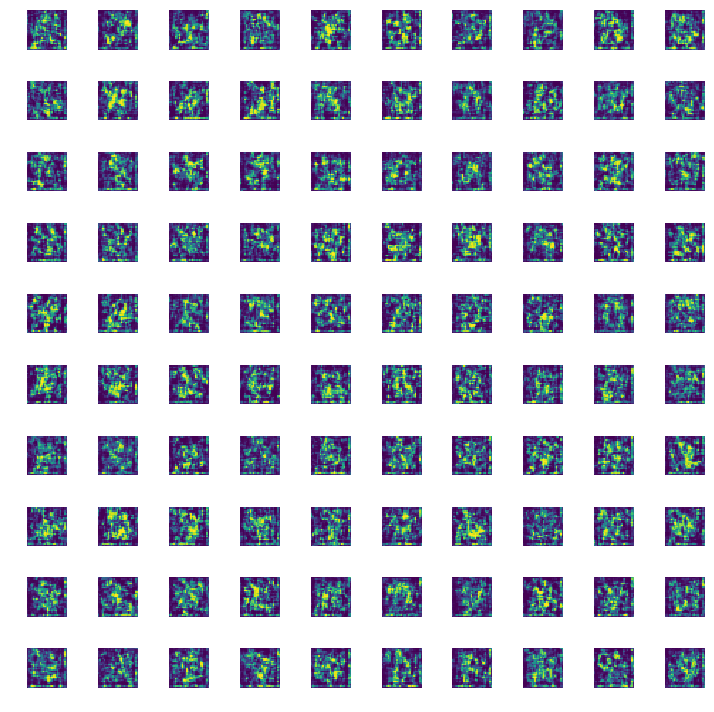

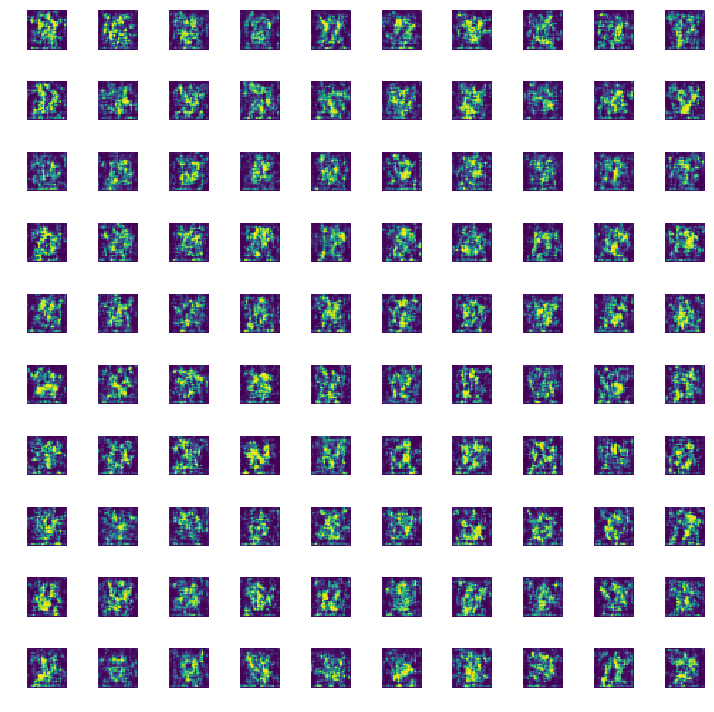

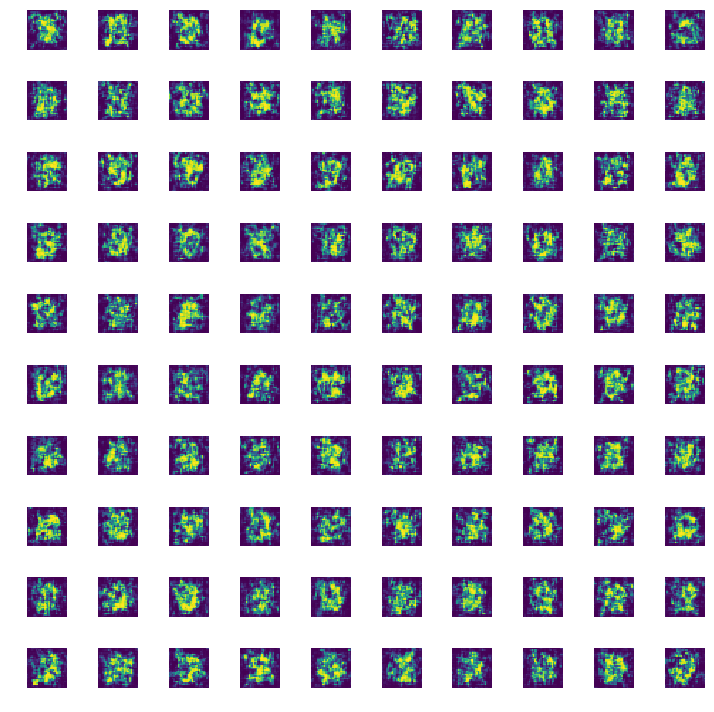

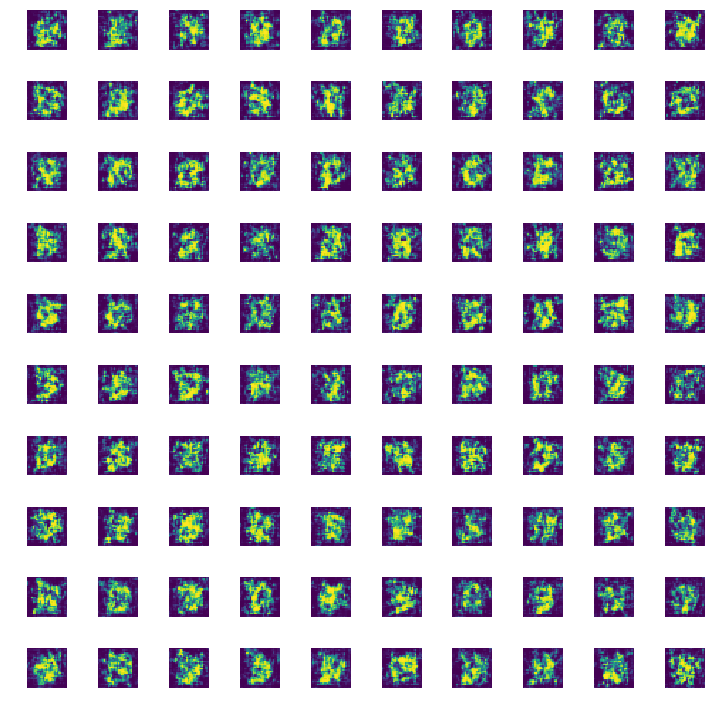

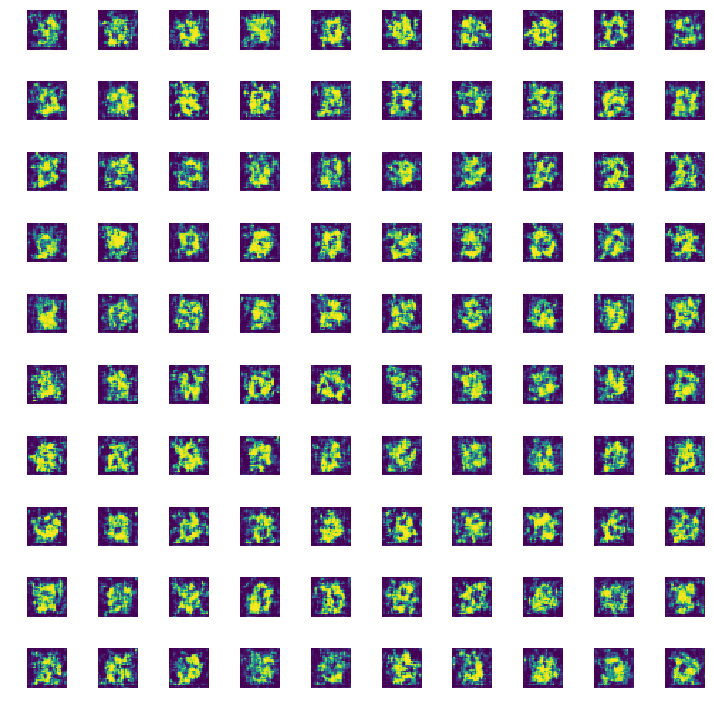

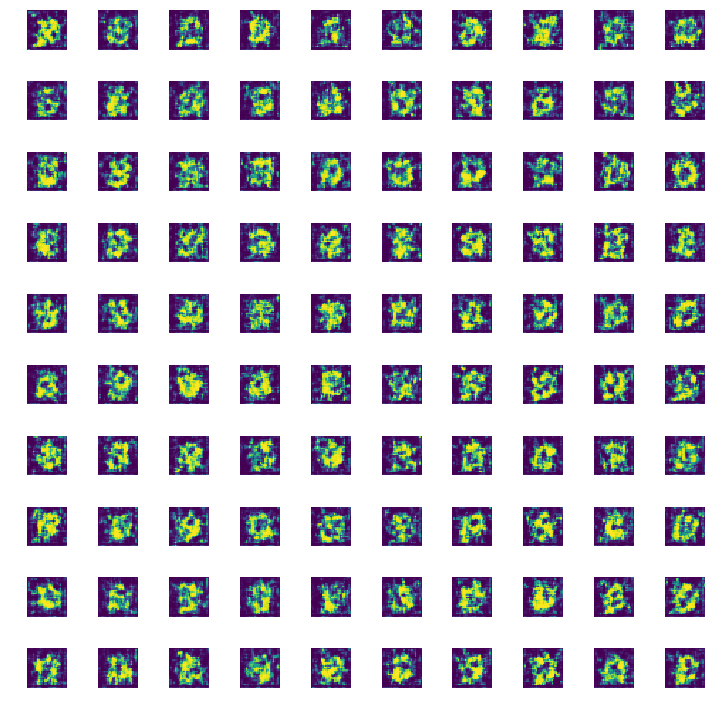

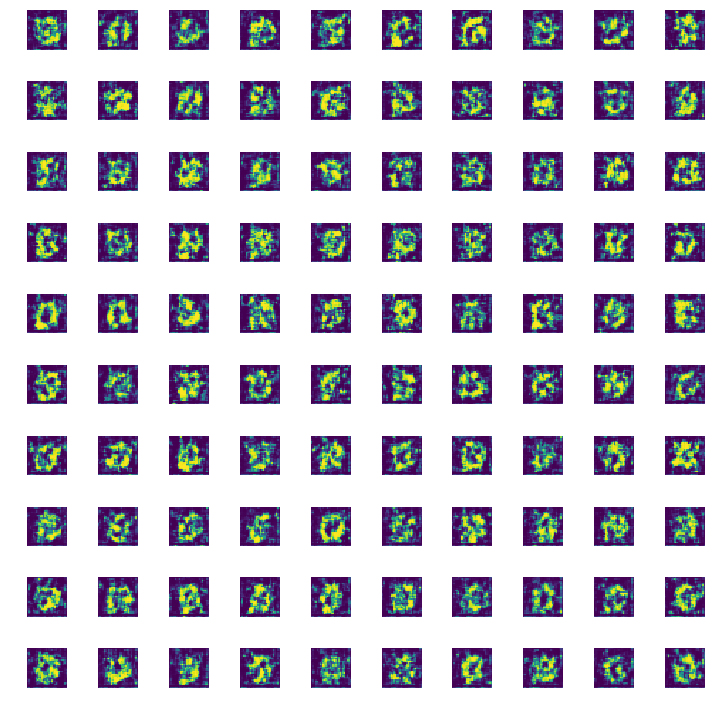

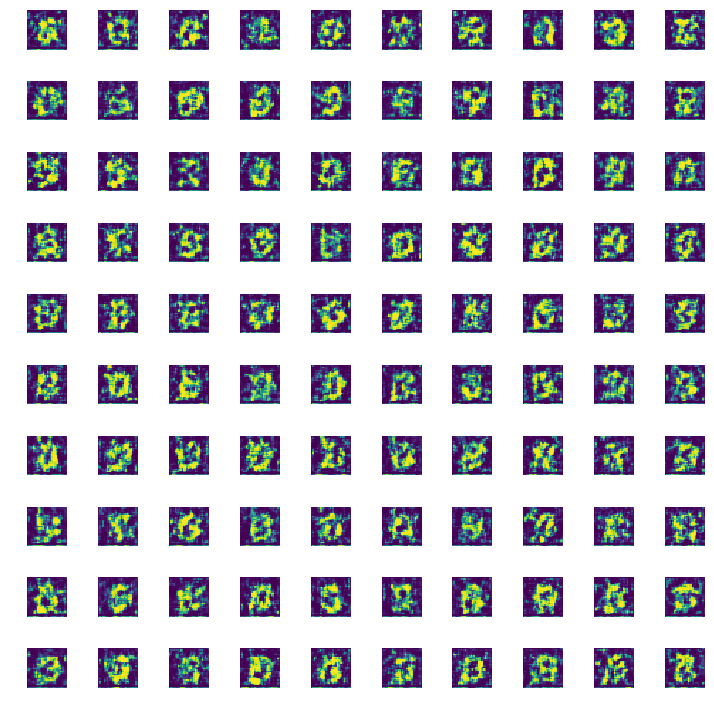

In [13]:
# Training for 100 epochs
train(100)